In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Data input and cleaning

In [2]:
import re
sns.set()
data800 = pd.read_csv("data800.csv", dtype={'time':np.float64})
data800['vox'] = 800

data40 = pd.read_csv("data40.csv", dtype={'time':np.float64})
data40['vox'] = 40

data = pd.concat([data40, data800], ignore_index=True)

data['error'] = [float(x[1:-1]) for x in data['fbest']]

def sanitize(data):
    return ''.join(filter(lambda x: x in ',.0123456789', data))

data['history'] = data['fhistory'].apply(sanitize)
data['ctime'] = data['currenttime'].apply(sanitize)

data['frac'] = data['sol'].str.count("1")/40

data = data.join(data['freq'].str.split(', ', expand=True).apply(pd.to_numeric))

data.drop(["fbest", "freq", "Unnamed: 0", "fhistory", "currenttime"], axis=1, inplace=True)
    
data.rename(columns=lambda x: x+1 if type(x)==int else x, inplace=True)

data.head()

,crossover,errorLimit,f1,grad,nPop,sol,time,vox,error,history,ctime,frac,1,2,3,4,5,6
0,NotModalSixPoint,0.01,75,150,40,1110011111010011111001000100111000000000,10814.631611,40,11.983678,"31.78390576,20.56259773,20.56259773,20.5625977...","361.0089016,488.02307749,608.41313672,716.9297...",0.475,72.542449,225.147099,346.176307,531.558687,725.976685,857.156869
1,NotModalSixPoint,0.01,75,150,40,0110111111110001001100110010011000000000,10811.122211,40,10.784153,"33.3268061,33.3268061,29.14432117,23.32827619,...","430.19342685,534.31689811,654.71736026,701.953...",0.450,73.506189,217.292723,347.818882,546.160542,712.068536,835.615592
2,NotModalSixPoint,0.01,75,150,40,1110111010100011101001100010001000000000,10819.008813,40,12.154765,"35.42591578,27.06929934,27.06929934,27.0692993...","389.32538033,515.25096512,633.40584636,757.752...",0.400,75.525838,230.031535,347.289069,508.163564,725.491010,863.167264
3,NotModalSixPoint,0.01,75,150,40,1001100111011111111110010011000000000100,10809.934290,40,11.214878,"28.85983137,25.56035478,21.57138858,19.3513473...","404.55849433,565.45567775,699.076087,771.12895...",0.500,72.063945,239.128806,366.041595,497.155998,704.742868,859.772915
4,NotModalSixPoint,0.01,75,150,40,0111101100111010011100100110010000000000,10820.403255,40,12.051828,"34.00364572,34.00364572,31.45298839,29.9553726...","381.67282343,485.63024163,609.12798524,742.376...",0.425,74.202585,219.914297,342.523994,527.466231,719.939105,861.395456


In [41]:
df = data.drop(['crossover', 'errorLimit', 'f1', 'grad', 'sol', 'nPop', 'time', 'history', 'ctime', 'frac', 'error'], axis=1)
df2 = pd.DataFrame()

for i, row in data.iterrows():
    for j in range(1, 7):
        df2 = df2.append(pd.Series([row[j], j, row["vox"]]), ignore_index=True)

df2.columns = ["freq", "mode", "vox"]
df2["error"] = (df2["freq"] - (-75 + df2["mode"]*150)) / (-75 + df2["mode"]*150) * 100
df2["abs_error"] = abs(df2["error"])   
df2["norm_error"] = abs(df2["error"])

error40 = df2.groupby("vox").mean()["abs_error"][40]
error800 = df2.groupby("vox").mean()["abs_error"][800]

print(error40, error800)

df2.loc[df2['vox'] == 40, 'norm_error'] = df2["norm_error"]/error40
df2.loc[df2['vox'] == 800, 'norm_error'] = df2["norm_error"]/error800
df2.head()

3.8708047721330443 13.34513952566149


,freq,mode,vox,error,abs_error,norm_error
0,72.542449,1.0,40.0,-3.276734,3.276734,0.846525
1,225.147099,2.0,40.0,0.065377,0.065377,0.016890
2,346.176307,3.0,40.0,-7.686318,7.686318,1.985716
3,531.558687,4.0,40.0,1.249274,1.249274,0.322743
4,725.976685,5.0,40.0,7.552102,7.552102,1.951042


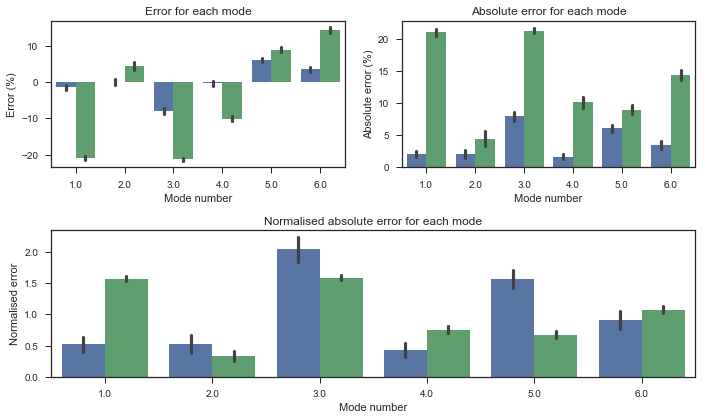

In [42]:
fig = plt.figure(figsize=(10, 6))
sns.set_style("ticks")

gs = plt.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])

sns.barplot(x="mode", y="error", hue="vox", data=df2, ax=ax1)
sns.barplot(x="mode", y="abs_error", hue="vox", data=df2, ax=ax2)
sns.barplot(x="mode", y="norm_error", hue="vox", data=df2, ax=ax3)

ax1.set_title("Error for each mode")
ax2.set_title("Absolute error for each mode")
ax3.set_title("Normalised absolute error for each mode")

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()

ax1.set_ylabel("Error (%)")
ax2.set_ylabel("Absolute error (%)")
ax3.set_ylabel("Normalised error")

ax1.set_xlabel("Mode number")
ax2.set_xlabel("Mode number")
ax3.set_xlabel("Mode number")

plt.tight_layout()
plt.savefig("nodalerrors.pgf")
plt.show()

In [5]:
errors = data.drop(['crossover', 'errorLimit', 'sol', 'time', 'history', 'frac', "f1", "grad"], axis=1)
errors.drop([x for x in errors.columns if type(x)==int], axis=1, inplace=True)
mean_errors = errors.groupby(["nPop"], as_index=False).describe()["error"]
dict_e = {x: 10+x*5 for x in range(7)}
dict_e.update({7: 50, 8: 60})
mean_errors.rename(index=dict_e)

,count,mean,std,min,25%,50%,75%,max
10,60.0,24.019671,12.559644,9.455229,11.647631,24.457905,36.520884,39.266962


In [6]:
history = data.drop(['crossover', 'errorLimit', 'sol', 'time', 'frac', "f1", "grad", "error"], axis=1)
history.drop([x for x in history.columns if type(x)==int], axis=1, inplace=True)
history = pd.concat([history, history['history'].str.split(',', expand=True).apply(pd.to_numeric)], axis=1)
history.drop(["history"], axis=1, inplace=True)

history["ctime"] = history['ctime'].str.split(',', expand=False).apply(pd.to_numeric)

history.head()

,nPop,vox,ctime,0,1,2,3,4,5,6,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,40,40,"[361.0089016, 488.02307749, 608.41313672, 716....",31.783906,20.562598,20.562598,20.562598,19.324376,19.324376,19.324376,...,11.983678,11.983678,11.983678,11.983678,11.983678,11.983678,11.983678,11.983678,11.983678,11.983678
1,40,40,"[430.19342685, 534.31689811, 654.71736026, 701...",33.326806,33.326806,29.144321,23.328276,23.328276,23.328276,23.328276,...,10.784153,10.784153,10.784153,10.784153,10.784153,10.784153,10.784153,10.784153,10.784153,10.784153
2,40,40,"[389.32538033, 515.25096512, 633.40584636, 757...",35.425916,27.069299,27.069299,27.069299,24.064043,24.064043,21.892797,...,12.154765,12.154765,12.154765,12.154765,12.154765,12.154765,12.154765,12.154765,12.154765,12.154765
3,40,40,"[404.55849433, 565.45567775, 699.076087, 771.1...",28.859831,25.560355,21.571389,19.351347,19.351347,14.606760,14.569105,...,11.214878,11.214878,11.214878,11.214878,11.214878,11.214878,11.214878,11.214878,11.214878,11.214878
4,40,40,"[381.67282343, 485.63024163, 609.12798524, 742...",34.003646,34.003646,31.452988,29.955373,27.708674,27.708674,26.313462,...,12.051828,12.051828,12.051828,12.051828,12.051828,12.051828,12.051828,12.051828,12.051828,12.051828


In [7]:
tseries = [[],[]]
for index, row in history.iterrows():
    tseries[1].append(pd.Series([row[x] for x in history.columns if type(x)==int], index=row["ctime"]/60))
    tseries[0].append(row["vox"])


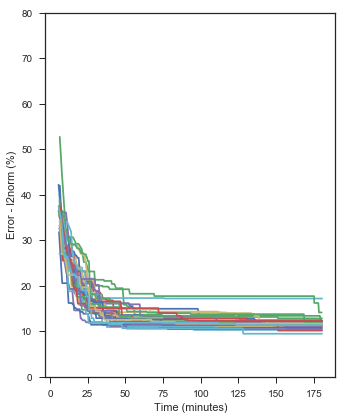

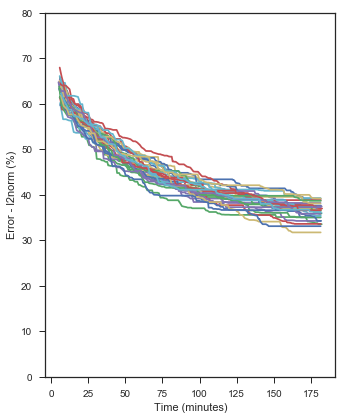

In [19]:
fig = plt.figure(figsize=(5, 6))
sns.set_style("ticks")

#for index, i in enumerate([40, 800]):
#fig.add_subplot(1, 2, index+1)
index = 0
i = 40
popseries = [tseries[1][x] for x in range(len(tseries[0])) if tseries[0][x] == i]
for k in popseries:
    plt.plot(k)
#plt.title("Voxel count = {}".format(i))
plt.xlabel("Time (minutes)")
plt.ylabel("Error - l2norm (%)")
plt.ylim([0, 80])

plt.tight_layout()
plt.savefig("voxcount.pgf")
plt.show()

fig = plt.figure(figsize=(5, 6))

index = 1
i = 800
popseries = [tseries[1][x] for x in range(len(tseries[0])) if tseries[0][x] == i]
for k in popseries:
    plt.plot(k)
#plt.title("Voxel count = {}".format(i))
plt.xlabel("Time (minutes)")
plt.ylabel("Error - l2norm (%)")
plt.ylim([0, 80])

plt.tight_layout()
plt.savefig("voxcount2.pgf")
plt.show()